In [1]:
pip install torch torchvision pillow matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import copy

In [2]:
# Image transformation pipeline
def load_image(image_path, max_size=512):
    image = Image.open(image_path).convert('RGB')
    
    # Resize to max_size while maintaining aspect ratio
    transform = transforms.Compose([
        transforms.Resize((max_size, max_size)),
        transforms.ToTensor()
    ])
    
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load content and style images
content_image = load_image("eiffel (1).jpg")
style_image = load_image("sunset.jpg")

In [3]:
# Load VGG-19 model
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Extract style & content layers from VGG-19
content_layers = ['conv_4']  
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

C:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
class VGGFeatures(nn.Module):
    def __init__(self, model, content_layers, style_layers):
        super(VGGFeatures, self).__init__()
        self.model = model
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.selected_layers = content_layers + style_layers

    def forward(self, x):
        content_features = {}
        style_features = {}

        for name, layer in self.model._modules.items():
            x = layer(x)

            if f"conv_{name}" in self.content_layers:
                content_features[f"conv_{name}"] = x
                
            if f"conv_{name}" in self.style_layers:
                style_features[f"conv_{name}"] = x

        return content_features, style_features

feature_extractor = VGGFeatures(vgg, content_layers, style_layers)


In [5]:
# Compute Gram Matrix for style loss
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    return torch.mm(tensor, tensor.t())

# Define the Style & Content Loss Functions
def compute_content_loss(content_feature, target_feature):
    return torch.mean((content_feature - target_feature) ** 2)

def compute_style_loss(style_features, target_features):
    loss = 0
    for layer in style_features:
        target_gram = gram_matrix(target_features[layer])
        style_gram = gram_matrix(style_features[layer])
        loss += torch.mean((target_gram - style_gram) ** 2)
    return loss


In [6]:
# Create the target image (clone of content image)
target = content_image.clone().requires_grad_(True)

# Set hyperparameters
optimizer = optim.Adam([target], lr=0.02)
num_steps = 700
alpha = 1  # Content weight
beta = 1e6  # Style weight

# Training loop
for step in range(num_steps):
    target_content_features, target_style_features = feature_extractor(target)
    content_features, style_features = feature_extractor(content_image)
    _, style_features_original = feature_extractor(style_image)

    content_loss = compute_content_loss(target_content_features['conv_4'], content_features['conv_4'])
    style_loss = compute_style_loss(style_features_original, target_style_features)

    total_loss = alpha * content_loss + beta * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step}, Loss: {total_loss.item()}")


Step 0, Loss: 1515430892011520.0
Step 50, Loss: 15847850508288.0
Step 100, Loss: 3829229682688.0
Step 150, Loss: 2409003483136.0
Step 200, Loss: 1810533842944.0
Step 250, Loss: 1447642136576.0
Step 300, Loss: 1193970761728.0
Step 350, Loss: 1002553344000.0
Step 400, Loss: 852086620160.0
Step 450, Loss: 730861076480.0
Step 500, Loss: 631442767872.0
Step 550, Loss: 548975312896.0
Step 600, Loss: 479822970880.0
Step 650, Loss: 421206753280.0


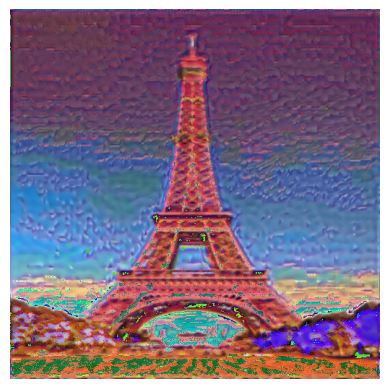

In [7]:
def show_image(tensor):
    image = tensor.cpu().clone().detach().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Show the final result
show_image(target)
